## Advanced Automation - Project Abalone (Group 1) - Decision Trees



Margarida Gralha (100222),
Tiago Neves (100272),
Rodrigo Amorim (100702)


## Import all libraries

In [11]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import graphviz
import matplotlib as mpl
import seaborn as sns
import scipy
import os
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, cross_validate
from sklearn import datasets
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

## Data processing

In [12]:
## LOAD DATASET
abl_df = pd.read_csv(os.path.abspath('abalone_data.csv'))
abl_df.head()


,Sex,Length (mm),Diameter (mm),Height (mm),Whole weight (g),Shucked weight (g),Viscera weight (g),Shell weight (g),Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [13]:
#Data that is going to be used 

abl_df_all = pd.get_dummies(abl_df,columns = ['Sex'],dtype=int)
x_all = abl_df_all.drop(['Rings','Sex_F','Sex_M'], axis = 1)
y = abl_df['Rings'].values.reshape(-1, 1)


seed = 1
X_train, X_val, y_train, y_val = train_test_split(x_all, y.reshape(-1,1), train_size=0.9, random_state=seed)
X_val

,Length (mm),Diameter (mm),Height (mm),Whole weight (g),Shucked weight (g),Viscera weight (g),Shell weight (g),Sex_I
17,0.440,0.340,0.100,0.4510,0.1880,0.0870,0.1300,0
1131,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,0
299,0.370,0.280,0.105,0.2340,0.0905,0.0585,0.0750,0
1338,0.580,0.455,0.135,0.7955,0.4050,0.1670,0.2040,0
2383,0.525,0.390,0.135,0.6005,0.2265,0.1310,0.2100,0
...,...,...,...,...,...,...,...,...
1104,0.510,0.405,0.125,0.6795,0.3465,0.1395,0.1820,1
3319,0.705,0.555,0.200,1.4685,0.4715,0.3235,0.5200,0
1227,0.350,0.255,0.090,0.1785,0.0855,0.0305,0.0525,1
2132,0.520,0.410,0.125,0.6985,0.2945,0.1625,0.2150,0


## Regression Tree

In [14]:
#Grid Search (Regression Tree)

kf =KFold(n_splits=5, shuffle=True, random_state=1)
tuned_parameters = [{'max_depth': [4,5,6,7,8,9,10]}]
clf = GridSearchCV(DecisionTreeRegressor(), tuned_parameters, cv=kf, scoring='neg_mean_squared_error', verbose = 3,n_jobs=-1)
clf.fit(X_train,y_train.ravel())

cv_results = pd.DataFrame(clf.cv_results_)
print(clf.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'max_depth': 6}


In [15]:
#Regression tree with all numeric features and Sex_I

regr_tree_abl = DecisionTreeRegressor(max_depth = clf.best_params_['max_depth'])
regr_tree_abl.fit(X_train,y_train.ravel())

y_pred = regr_tree_abl.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('Test Mean Squared Error = ' + str(mse))

Test Mean Squared Error = 5.005857848336492


                    Importance
Shell weight (g)     77.074040
Shucked weight (g)   15.670577
Sex_I                 2.371018
Diameter (mm)         2.295299
Height (mm)           1.106051
Length (mm)           0.891522
Whole weight (g)      0.511770
Viscera weight (g)    0.079723


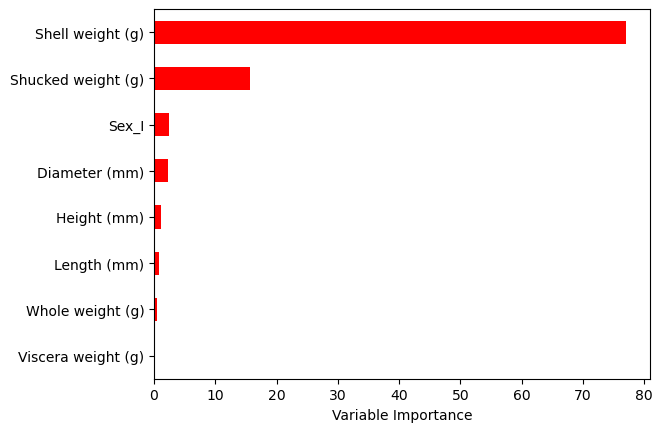

In [16]:
#Importance Variables (Random Forrests with all the numeric variables and Sex_I) 
importance = pd.DataFrame({'Importance':regr_tree_abl.feature_importances_*100}, 
                          index = X_train.columns)

importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'red', )

Importance = importance.sort_values(by = 'Importance', ascending = False)
print(Importance)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

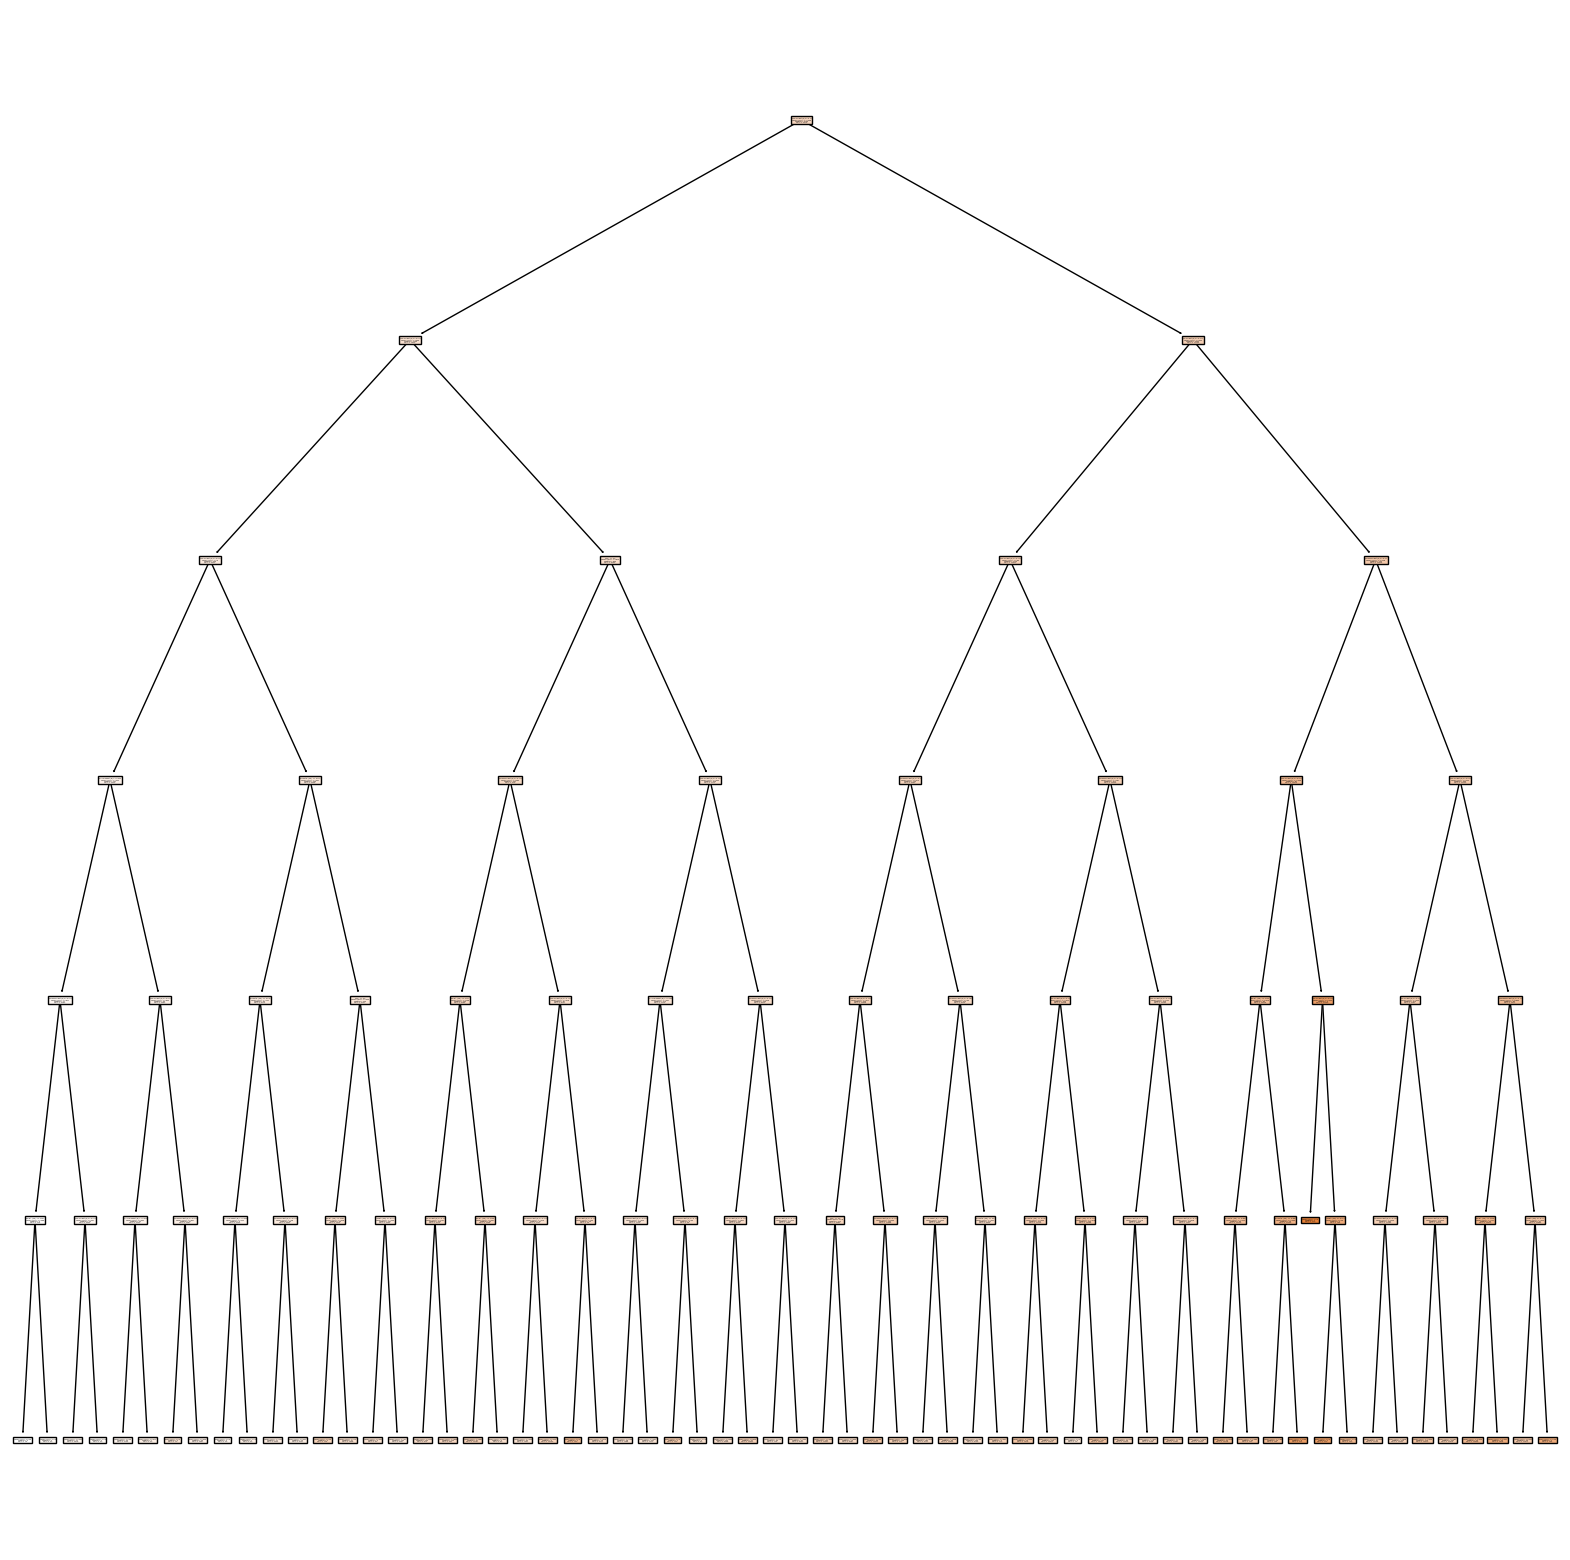

In [17]:
#Plot the first Regression Tree 

fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(regr_tree_abl, feature_names=X_train.columns.tolist(), filled=True)

## Random Forests

In [25]:
#Grid Search 

kf =KFold(n_splits=5, shuffle=True, random_state=1)
tuned_parameters = [{'max_depth': [6,7,8,9,10], 'n_estimators':[10,50,100,150,200], 'min_samples_split':[2,3,4]}]
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=kf, scoring='neg_mean_squared_error', verbose = 3,n_jobs=-1)
clf.fit(X_train,y_train.ravel())

cv_results = pd.DataFrame(clf.cv_results_)
print(clf.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 100}


In [19]:
# Random forests: using 3 features (Using only numerical variables and Sex_I)

residuals = []
random_forest_abl = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],
                                           max_features=3,
                                           max_depth=clf.best_params_['max_depth'],
                                           min_samples_split=clf.best_params_['min_samples_split'],
                                           random_state=1, bootstrap=True)
random_forest_abl.fit(X_train, y_train.ravel())

y_pred = random_forest_abl.predict(X_val)
residuals= y_pred - y_val.ravel()
mse = mean_squared_error(y_val, y_pred)
print('Test Mean Squared Error = ' + str(mse))

Test Mean Squared Error = 4.368369652454525


                    Importance
Shell weight (g)     33.842563
Height (mm)          15.844625
Whole weight (g)     13.115503
Shucked weight (g)   12.303527
Diameter (mm)         9.262826
Viscera weight (g)    8.739562
Length (mm)           4.878315
Sex_I                 2.013079


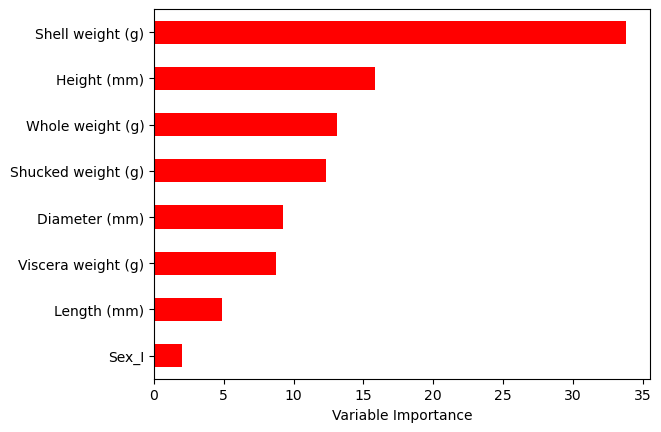

In [20]:
#Importance Variables (Random Forests with all the numeric variables and Sex_I) 
importance = pd.DataFrame({'Importance':random_forest_abl.feature_importances_*100}, 
                          index = X_train.columns)

importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'red', )

Importance = importance.sort_values(by = 'Importance', ascending = False)
print(Importance)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

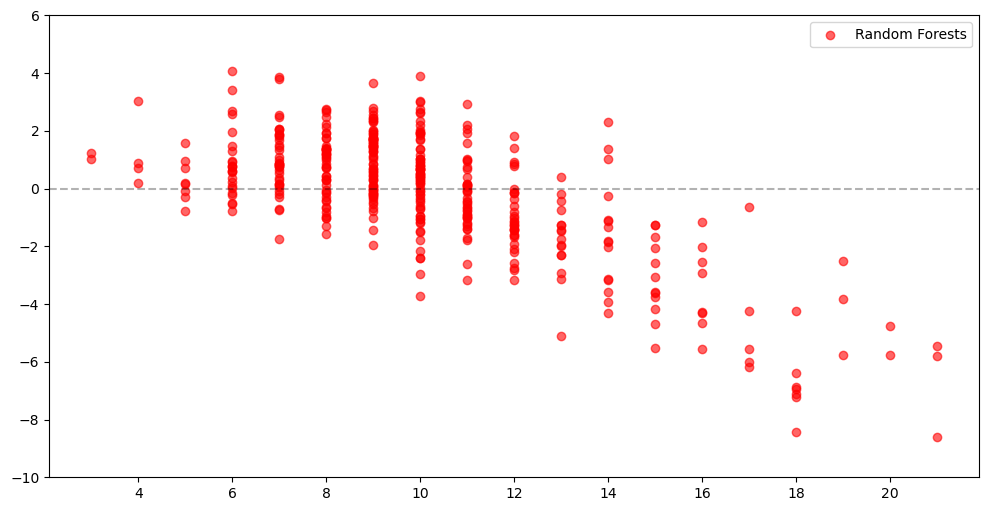

In [26]:
#Residuals of the Random Forests Model
from matplotlib.ticker import MultipleLocator

plt.rcParams['figure.figsize'] = [12, 6]
plt.scatter( y_val.ravel(), residuals, alpha=0.6, color = 'red')
plt.axhline(y=0, linestyle='--', color='black', label='y=0', alpha=0.3)
plt.ylim([-10, 6])
plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.legend(labels=['Random Forests'], loc='upper right')
plt.show()

## Gradient Boosting 

In [22]:
#Grid Search
kf =KFold(n_splits=5, shuffle=True, random_state=1)
tuned_parameters = [{'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5], 'max_depth': [2,3,4,5], 'n_estimators': [500,750,1000,2000]}]
clf = GridSearchCV(GradientBoostingRegressor(), tuned_parameters, cv=kf, scoring='neg_mean_squared_error', verbose = 3,n_jobs=-1)
clf.fit(X_train,y_train.ravel())

cv_results = pd.DataFrame(clf.cv_results_)
print(clf.best_params_)


Fitting 5 folds for each of 112 candidates, totalling 560 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}


In [23]:
#Gradient Boosting with all the variables (Accounting only for Sex_I)
boosted_abl = GradientBoostingRegressor(n_estimators = clf.best_params_['n_estimators'], 
                                           learning_rate = clf.best_params_['learning_rate'], 
                                           max_depth = clf.best_params_['max_depth'], 
                                           random_state = 1)

boosted_abl.fit(X_train,y_train.ravel())
y_pred = boosted_abl.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('Test Mean Squared Error = ' + str(mse))

Test Mean Squared Error = 4.481202644212001


                    Importance
Shell weight (g)     68.791968
Shucked weight (g)   16.183844
Whole weight (g)      4.414278
Height (mm)           3.433680
Sex_I                 2.346175
Diameter (mm)         2.068412
Length (mm)           1.464041
Viscera weight (g)    1.297602


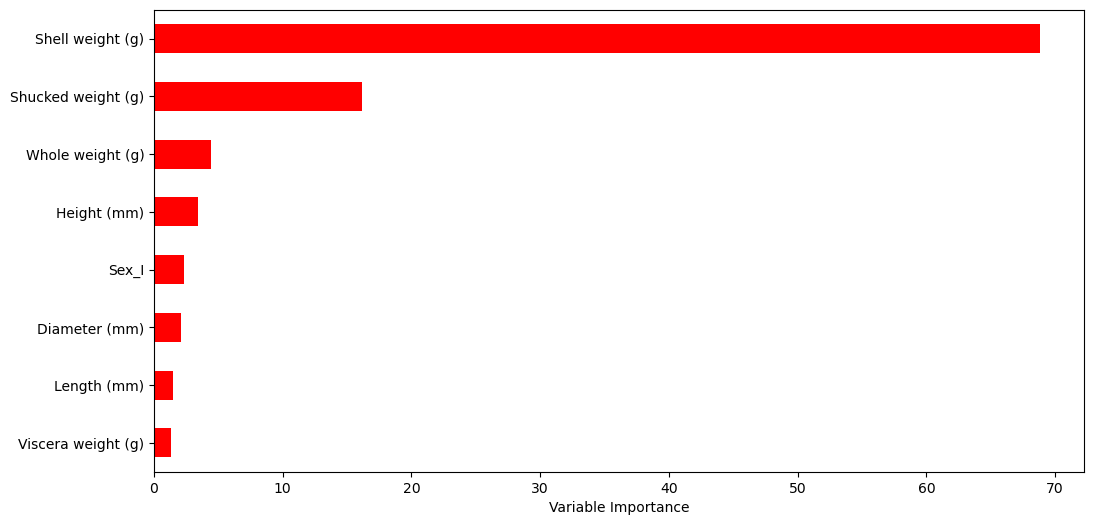

In [24]:
#Importance Features
importance = pd.DataFrame({'Importance':boosted_abl.feature_importances_*100}, 
                          index = X_train.columns)

importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'red', )

Importance = importance.sort_values(by = 'Importance', ascending = False)
print(Importance)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None